Red Flag Report JAN 2022 - JUN 2022<a href="#Red-Flag-Report-JAN-2022---JUN-2022" class="anchor-link">¶</a>
===========================================================================================================

Read in data<a href="#Read-in-data" class="anchor-link">¶</a>
=============================================================

drop description column and last row  
drop dummy part number

In \[24\]:

    import pandas as pd
    import numpy as np
    from datetime import datetime
    from tqdm import tqdm

In \[25\]:

    df = pd.read_excel('redflag_data_220801.xlsx', sheet_name = 'Report', header = 8)
    del df[df.columns[0]]
    df.drop(['Unnamed: 2'], inplace = True, axis = 1)
    df = df[df['Mat_#_M+H_installed'] != 'PWYEMA1000'] #dummy part number
    df

Out\[25\]:

|       | Mat\_\#\_M+H\_installed | M+H\_Proj\_\#\_new | Cust\_2\_Group\_L2 | M+H\_Plant\_2\_Comp\_Code | Date\_Veh\_Repair\_Y/M | Date\_Veh\_Prod\_Y/M | Veh\_Repair\_1\_Country | Number of claims |
|-------|-------------------------|--------------------|--------------------|---------------------------|------------------------|----------------------|-------------------------|------------------|
| 0     | 0152000S01              | EP-JAG1015-06      | JLR Jaguar         | MHUK                      | MAY 2022               | OCT 2018             | USA                     | 1                |
| 1     | 0201801524              | \#                 | GM Korea           | MHKR                      | FEB 2022               | FEB 2019             | USA                     | 1                |
| 2     | 0201801524              | \#                 | GM Korea           | MHKR                      | JUN 2022               | FEB 2019             | USA                     | 1                |
| 3     | 0213030002              | \#                 | Ford               | MHMX                      | APR 2022               | APR 2015             | USA                     | 1                |
| 4     | 0213030002              | \#                 | Ford               | MHMX                      | APR 2022               | APR 2016             | USA                     | 1                |
| ...   | ...                     | ...                | ...                | ...                       | ...                    | ...                  | ...                     | ...              |
| 38915 | UFRFA1916               | \#                 | Ford               | MPUS                      | MAY 2022               | OCT 2017             | USA                     | 1                |
| 38916 | UFRFA1916               | \#                 | Ford               | MPUS                      | MAY 2022               | SEP 2015             | USA                     | 1                |
| 38917 | UFRFA1916               | \#                 | Ford               | MPUS                      | MAY 2022               | SEP 2019             | Not assigned            | 1                |
| 38918 | UFRFA1918               | \#                 | Ford               | MPUS                      | APR 2022               | JUN 2020             | USA                     | 1                |
| 38919 | UFRFA1918               | \#                 | Ford               | MPUS                      | MAY 2022               | SEP 2019             | USA                     | 1                |

38275 rows × 8 columns

Result dataframe with part number and total number of claims<a href="#Result-dataframe-with-part-number-and-total-number-of-claims" class="anchor-link">¶</a>
=============================================================================================================================================================

In \[26\]:

    result = df.groupby(['Mat_#_M+H_installed', 'M+H_Proj_#_new'], as_index=False).agg(
        customer = ('Cust_2_Group_L2', 'unique'),
        MH_plant = ('M+H_Plant_2_Comp_Code', 'unique'),
        number_of_claims = ('Number of claims', sum)
    )
    #1599 unique part numbers
    result

Out\[26\]:

|      | Mat\_\#\_M+H\_installed | M+H\_Proj\_\#\_new | customer             | MH\_plant | number\_of\_claims |
|------|-------------------------|--------------------|----------------------|-----------|--------------------|
| 0    | 0152000S01              | EP-JAG1015-06      | \[JLR Jaguar\]       | \[MHUK\]  | 1                  |
| 1    | 0201801524              | \#                 | \[GM Korea\]         | \[MHKR\]  | 2                  |
| 2    | 0213030002              | \#                 | \[Ford\]             | \[MHMX\]  | 187                |
| 3    | 0213030003              | MHES-Z-001         | \[Ford\]             | \[MHMX\]  | 98                 |
| 4    | 0213030004              | \#                 | \[GM North America\] | \[MHMX\]  | 1                  |
| ...  | ...                     | ...                | ...                  | ...       | ...                |
| 1594 | UFRFA1902               | \#                 | \[Ford\]             | \[MPUS\]  | 231                |
| 1595 | UFRFA1910               | \#                 | \[Ford\]             | \[MPUS\]  | 54                 |
| 1596 | UFRFA1911               | \#                 | \[Ford\]             | \[MPUS\]  | 24                 |
| 1597 | UFRFA1916               | \#                 | \[Ford\]             | \[MPUS\]  | 269                |
| 1598 | UFRFA1918               | \#                 | \[Ford\]             | \[MPUS\]  | 2                  |

1599 rows × 5 columns

F1 Flag<a href="#F1-Flag" class="anchor-link">¶</a>
===================================================

Production date (Y/M):  
IF number of claims of month x \> 3 \* number of claims of month x-1  
AND  
number of claims of month x \> 5  
THEN set alert

In \[27\]:

    #remove invalid rows
    production_df = df[df['Date_Veh_Prod_Y/M'] != 'Not assigned']

    F1_timestamp = pd.to_datetime('JUN 2017', format = '%b %Y')
    td = pd.Timedelta(31, "d") # 31 days
    multiplier = 3

    #a list to store F1 flags for each part number
    F1_list = []
    F1_description = []


    production = production_df.groupby('Mat_#_M+H_installed')

    #a function to generate F1 signals based on production months
    def cal_F1_prod(part):
        
        #create a dataframe containing series of production months
        p = production.get_group(part).groupby('Date_Veh_Prod_Y/M')[['Number of claims']].sum()
        p.reset_index(inplace = True)
        
        #transform production months to datetime and sort them
        p['Date_Veh_Prod_Y/M'] = pd.to_datetime(p['Date_Veh_Prod_Y/M'], format = '%b %Y')
        p = p.sort_values('Date_Veh_Prod_Y/M')
        p = p.reset_index(drop = True)
        
        #extract past 5-years production months (june 2017 - june 2022)
        p = p[p['Date_Veh_Prod_Y/M'] >= F1_timestamp]
        
        #create colums showing difference of claim numbers and production months between rows
        p['num_change'] = p['Number of claims'].pct_change() + 1
        p['time_diff'] = p['Date_Veh_Prod_Y/M'].diff()
        p['num_change'] = np.roll(p['num_change'], -1)
        p['time_diff'] = np.roll(p['time_diff'], -1)
        
        #caculate F1 signals based on F1 conditions, if the change is greater than 3 and if they are adjacent months
        p['F1_signal'] = np.where((p["Number of claims"] > 5) & (p['num_change'] >= multiplier) & (p['time_diff'] <= td), 1, 0)
        
        p = p[p['F1_signal'] > 0]
        
        return p



    #caculate F1 flag for each part number, then append to F1_list
    for pn in tqdm(result['Mat_#_M+H_installed']):
        if pn not in production.groups.keys():
            F1_list.append(0)
            F1_description.append("")
            continue
            
        F1_result_pn = cal_F1_prod(pn)
        
        if F1_result_pn.empty == False:
            F1_list.append(F1_result_pn['F1_signal'].sum())
            F1_result_pn['Date_Veh_Prod_Y/M'] = F1_result_pn['Date_Veh_Prod_Y/M'].dt.strftime('%b %Y')
            # description of which month triggers F1
            F1_description.append("increase in " + " , ".join(F1_result_pn['Date_Veh_Prod_Y/M']) + " production")
        else:
            F1_list.append(0)
            F1_description.append("")
            
        
    #add F1_list as a column to result dataframe
    result = result.assign(F1_flag = F1_list)
    result = result.assign(F1_description = F1_description)
    result['F1_flag'] = np.where(result['F1_flag'] > 0, 1, 0)

    100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [00:26<00:00, 60.62it/s]

In \[28\]:

    result['F1_flag'].sum()

Out\[28\]:

    24

F2 Flag<a href="#F2-Flag" class="anchor-link">¶</a>
===================================================

Repair date (Y/M):  
IF number of claims of last 4 consequential months have a trend \> 0  
AND  
average number of claims is \> 5  
THEN set alert

In \[29\]:

    #group by repair month
    repair = df.groupby('Date_Veh_Repair_Y/M')

    #transform repair month to datetime
    repair_months = pd.to_datetime(df['Date_Veh_Repair_Y/M'], format = '%b %Y')

    #use past 6 months data
    time_period = 6



    #a function to create a column of number of claims of each part number in a certain repair month
    def repair_column(month):
        repair_month_sum = repair.get_group(month).groupby('Mat_#_M+H_installed')[['Number of claims']].sum()
        repair_month_sum.reset_index(inplace = True)
        repair_month_sum.rename(columns = {'Number of claims' : month}, inplace = True)
        return repair_month_sum


    #for each unique repair month, merge associated column to result dataframe
    for t in sorted(set(repair_months.values)):
        m = pd.to_datetime(str(t)).strftime('%b %Y').upper()
        result = pd.merge(result, repair_column(m), how = "left")
        
    result = result.fillna(0)



    #caculate past 4 months trend
    result['trend_4months'] = np.where(result.iloc[: , time_period + 6] + result.iloc[: , time_period + 5] 
                                       > result.iloc[: , time_period + 4] + result.iloc[: , time_period + 3], 1, 0)

    #drop unnecessary columns
    result.drop(result.iloc[: , 7 : time_period + 7], inplace = True, axis = 1)

    #caculate average number of claims
    result['average num of claims'] = result['number_of_claims'] / time_period

    #caculate F2 flags
    result['F2_flag'] = np.where((result["trend_4months"] > 0) & (result["average num of claims"].round() >= 5), 1, 0)

    #drop unnecessary columns
    result.drop(['trend_4months', 'average num of claims'], inplace = True, axis = 1)

In \[30\]:

    result['F2_flag'].sum()

Out\[30\]:

    36

F3 Flag<a href="#F3-Flag" class="anchor-link">¶</a>
===================================================

Country of failure:  
Assume countries not in market table each have 0.01% market share  
Only look at top 3 most number of claims countries for each part
number  
IF number of claims (per country per part number) \> 20  
AND  
deviation from market table \> 2000%  
THEN set alert  

In \[31\]:

    #read in market share table
    market_table = pd.read_excel('Mappe2.xlsx')
    market_table.drop(['2021'], inplace = True, axis = 1)
    market_table.rename(columns = {'Key Figures|Calendar Year' : 'Veh_Repair_1_Country'}, inplace = True)

    country_df = df[df['Veh_Repair_1_Country'] != 'Not assigned']
    F3_list = []
    F3_description = []

    country = country_df.groupby('Mat_#_M+H_installed')

    def cal_F3(part):
        
        c = country.get_group(part).groupby('Veh_Repair_1_Country')[['Number of claims']].sum()
        c.reset_index(inplace = True)
        total_claims = c['Number of claims'].sum()
        
        #calculate market share percentage of each country for this part number
        c['pn_percentage'] = c['Number of claims'] / total_claims
        c = pd.merge(c, market_table, how = "left")
        
        #assume countries not in market table each have 0.01% market share
        c = c.fillna(0.0001)
        
        #calculate deviation from market table
        c['diff'] = c['pn_percentage'] / c['Percentage']
        
        #only look at top 3 most number of claims countries for each part number
        c = c.sort_values(by='Number of claims', ascending=False).head(3)
        
        #caculate F3 signals based on F3 conditions
        c['F3_signal'] = np.where((c['diff'] > 20) & (c['Number of claims'] > 20), 1, 0)
        
        return c[c['F3_signal'] > 0]

    for pn in tqdm(result['Mat_#_M+H_installed']):
        if pn not in country.groups.keys():
            F3_list.append(0)
            F3_description.append("")
            continue
            
        F3_result_pn = cal_F3(pn)
        
        if F3_result_pn.empty == False:
            F3_list.append(F3_result_pn['F3_signal'].sum())
            F3_result_pn['diff'] = F3_result_pn['diff'].map('{:.2%}'.format)
            #description of which country triggers F3
            F3_description.append(" , ".join(F3_result_pn['Veh_Repair_1_Country']) + " : " + 
                                  " , ".join(F3_result_pn['diff']))
        else:
            F3_list.append(0)
            F3_description.append("")

    result = result.assign(F3_flag = F3_list)
    result = result.assign(F3_description = F3_description)
    result['F3_flag'] = np.where(result['F3_flag'] > 0, 1, 0)

    100%|██████████████████████████████████████████████████████████████████████████████| 1599/1599 [00:17<00:00, 91.93it/s]

In \[32\]:

    result['F3_flag'].sum()

Out\[32\]:

    72

Clustering<a href="#Clustering" class="anchor-link">¶</a>
=========================================================

run k-means clustering with three features:  
'Months\_in\_Service', 'Number of claims', 'amount\_claimed'  
got 5 clusters  

In \[33\]:

    import matplotlib.pyplot as plt
    %matplotlib inline
    import seaborn as sns
    sns.set_style('darkgrid')
    import plotly.express as px
    from scipy import stats
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from yellowbrick.cluster import KElbowVisualizer

    cluster_df = pd.read_excel('../cluster/clustering_data_220801.xlsx', sheet_name = 'Report', header = 9) # JAN 2022 - JUN 2022
    del cluster_df[cluster_df.columns[0]]
    cluster_df.drop(['Unnamed: 2'], inplace = True, axis = 1)
    cluster_df = cluster_df[cluster_df['Mat_#_M+H_installed'] != 'PWYEMA1000'] #dummy part number
    cluster_df.rename(columns = {'Unnamed: 15' : 'Number of claims'}, inplace = True)
    cluster_df.rename(columns = {'EUR' : 'amount_claimed'}, inplace = True)

    #preprocessing
    cluster_df['Months_in_Service'] = cluster_df['Months_in_Service'].replace(['#'], 0)
    cluster_df['Months_in_Service'] = cluster_df['Months_in_Service'].astype(int)
    cluster_df_clean = cluster_df[(stats.zscore(cluster_df['Months_in_Service']) < 5)]
    cluster_df_clean.set_index(['Veh_VIN_#'], inplace = True)

    #selecting features
    X = cluster_df_clean.copy()
    X = X[['Months_in_Service', 'Number of claims', 'amount_claimed']]

    #standardize data
    X_cols = X.columns
    scaler = StandardScaler()
    seed = np.random.seed(1182)
    X_scaled = scaler.fit_transform(X)

    #find optimal k
    visualizer = KElbowVisualizer(KMeans(random_state = 1182), k = (2,11))

    visualizer.fit(X_scaled) # Fit the data to the visualizer

    #fit k-means model on data
    model_k = KMeans(n_clusters = visualizer.elbow_value_, random_state = 1182).fit(X_scaled)
    cluster_df_clean['cluster_label'] = model_k.labels_
    cluster_df_clean.cluster_label.value_counts()

    C:\Users\353983\AppData\Local\Temp\ipykernel_8296\3140739918.py:39: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      cluster_df_clean['cluster_label'] = model_k.labels_

Out\[33\]:

    0    60707
    1    18689
    3      753
    2       70
    4        1
    Name: cluster_label, dtype: int64

![](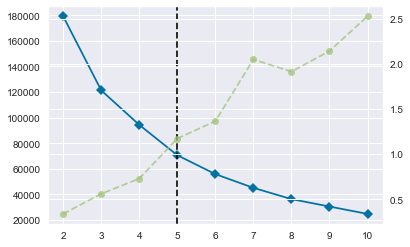%0A)

In \[34\]:

    #get top 20 part numbers with most number of claims
    def cluster_flag(cluster_df):
        cluster_df['Months_in_Service'] = cluster_df['Months_in_Service'] * cluster_df['Number of claims']
        cluster_pn = cluster_df.groupby('Mat_#_M+H_installed', as_index = False).agg(
            total_claims = ('Number of claims', sum),
            total_months_in_service = ('Months_in_Service', sum),
            total_amount_claimed = ('amount_claimed', sum)
        )
        
        cluster_pn['avg_months_in_service'] = cluster_pn['total_months_in_service'] / cluster_pn['total_claims']
        cluster_pn['avg_amount_claimed'] = cluster_pn['total_amount_claimed'] / cluster_pn['total_claims']
        
        cluster_pn = cluster_pn.sort_values(by = 'total_claims', ascending = False).head(20)
        
        cluster_pn.drop('total_months_in_service', axis = 1, inplace = True)
        cluster_pn.drop('total_amount_claimed', axis = 1, inplace = True)
        
        cluster_pn = cluster_pn.reset_index(drop = True)
        
        return cluster_pn

F4 flag<a href="#F4-flag" class="anchor-link">¶</a>
===================================================

top 20 part numbers with large number of claims

In \[35\]:

    #choosing the cluster with max number of members as large num of claim cluster
    cluster_index = cluster_df_clean.cluster_label.value_counts().sort_values().index[visualizer.elbow_value_ - 1]
    df_cluster_F4 = cluster_df_clean[cluster_df_clean['cluster_label'] == cluster_index]
    F4_df = cluster_flag(df_cluster_F4)
    F4_df = F4_df.round(2)
    result['F4_flag'] = np.where(result['Mat_#_M+H_installed'].isin(F4_df['Mat_#_M+H_installed']), 1, 0)
    result['F4_flag'].sum()

    C:\Users\353983\AppData\Local\Temp\ipykernel_8296\2929095623.py:3: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      cluster_df['Months_in_Service'] = cluster_df['Months_in_Service'] * cluster_df['Number of claims']

Out\[35\]:

    20

F5 flag<a href="#F5-flag" class="anchor-link">¶</a>
===================================================

top 20 part numbers with high amount claimed

In \[36\]:

    #choosing the cluster with middle number of members as financialy important cluster
    cluster_index = cluster_df_clean.cluster_label.value_counts().sort_values().index[visualizer.elbow_value_ // 2]
    df_cluster_F5 = cluster_df_clean[cluster_df_clean['cluster_label'] == cluster_index]
    F5_df = cluster_flag(df_cluster_F5)
    F5_df = F5_df.round(2)
    result['F5_flag'] = np.where(result['Mat_#_M+H_installed'].isin(F5_df['Mat_#_M+H_installed']), 1, 0)
    result['F5_flag'].sum()

    C:\Users\353983\AppData\Local\Temp\ipykernel_8296\2929095623.py:3: SettingWithCopyWarning: 
    A value is trying to be set on a copy of a slice from a DataFrame.
    Try using .loc[row_indexer,col_indexer] = value instead

    See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      cluster_df['Months_in_Service'] = cluster_df['Months_in_Service'] * cluster_df['Number of claims']

Out\[36\]:

    20

Total number of flags<a href="#Total-number-of-flags" class="anchor-link">¶</a>
===============================================================================

In \[37\]:

    result['# Flags hit'] = 0
    #calculate sum of F1 - F5 flags
    for i in range(1,6):
        result['# Flags hit'] += result['F' + str(i) + '_flag']
    result['# Flags hit'].sum()

Out\[37\]:

    172

In \[38\]:

    result = result[result['# Flags hit'] > 0]
    result = result.sort_values('# Flags hit', ascending=False)
    result #132 part numbers

Out\[38\]:

|      | Mat\_\#\_M+H\_installed | M+H\_Proj\_\#\_new | customer                   | MH\_plant | number\_of\_claims | F1\_flag | F1\_description                                   | F2\_flag | F3\_flag | F3\_description          | F4\_flag | F5\_flag | \# Flags hit |
|------|-------------------------|--------------------|----------------------------|-----------|--------------------|----------|---------------------------------------------------|----------|----------|--------------------------|----------|----------|--------------|
| 162  | 1059775S01              | EP-GM1074-02       | \[GM North America, Opel\] | \[MHDE\]  | 609                | 0        |                                                   | 1        | 1        | South Korea : 2149.94%   | 1        | 0        | 3            |
| 1168 | 1343909S01              | EP-DCT1157-05      | \[Daimler Truck\]          | \[MHDE\]  | 1193               | 1        | increase in Dec 2019 , May 2020 production        | 0        | 1        | South Africa : 11713.89% | 1        | 0        | 3            |
| 1392 | 2302933121              | N020               | \[Daimler Truck\]          | \[MHDE\]  | 2456               | 1        | increase in Feb 2019 , Dec 2019 , May 2020 pro... | 0        | 1        | South Africa : 10486.68% | 1        | 0        | 3            |
| 188  | 1070938S01              | \#                 | \[Daimler Truck\]          | \[MHDE\]  | 646                | 1        | increase in Jun 2019 , Jun 2020 production        | 0        | 1        | Brazil : 3001.08%        | 1        | 0        | 3            |
| 1167 | 1343898S01              | \#                 | \[Daimler Truck\]          | \[MHDE\]  | 3368               | 1        | increase in Feb 2019 , Apr 2020 production        | 0        | 1        | South Africa : 2872.27%  | 1        | 0        | 3            |
| ...  | ...                     | ...                | ...                        | ...       | ...                | ...      | ...                                               | ...      | ...      | ...                      | ...      | ...      | ...          |
| 476  | 1152124S01              | EP-FOR0108-02      | \[Ford\]                   | \[MHUK\]  | 560                | 0        |                                                   | 0        | 0        |                          | 0        | 1        | 1            |
| 464  | 1148094S51              | MHBR-001           | \[Volkswagen\]             | \[MHBR\]  | 103                | 0        |                                                   | 0        | 1        | Brazil : 2126.98%        | 0        | 0        | 1            |
| 451  | 1132957V56              | EP-BMW1126-10      | \[BMW\]                    | \[MHDE\]  | 68                 | 0        |                                                   | 0        | 1        | Thailand : 4022.31%      | 0        | 0        | 1            |
| 429  | 1126901S54              | EP-FRE1018         | \[Daimler Trucks NA\]      | \[MHMX\]  | 42                 | 0        |                                                   | 1        | 0        |                          | 0        | 0        | 1            |
| 1593 | UFRFA1883B7             | \#                 | \[Ford\]                   | \[MPUS\]  | 189                | 0        |                                                   | 1        | 0        |                          | 0        | 0        | 1            |

132 rows × 13 columns

In \[39\]:

    result.to_excel('redflag_report_220805.xlsx', index=False)

In \[ \]: